# Bootstrap Sampling

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/v1/12_bootstrap.ipynb).

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/v1/utils.py')

import utils

In the previous chapter we used resampling to compute sampling distributions, which quantify the variability in an estimate due to random sampling.

In this chapter, we'll use data from the General Social Survey (GSS) to estimate average income and the 10th percentile of income.
We'll see that the resampling method we used in the previous chapter works for the average but not for the 10th percentile.
To solve this problem, we'll use another kind of resampling, called bootstrapping.

Then we'll use bootstrapping to compute sampling distributions for correlations and the parameters of linear regression.
Finally, I'll point out a problem with bootstrap resampling when there are not enough different values in a dataset, and a way to solve it with KDE resampling.

## Estimating Average Income

As a first example, we'll use data from the General Social Survey to estimate average family income.
We'll work with an extract that contains just the columns we need, as we did in Chapter 8.
Instructions for downloading the extract are in the notebook for this chapter.

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
download('https://github.com/AllenDowney/ElementsOfDataScience/' +
         'raw/v1/data/gss_extract_2022.hdf');

We can load the data like this and display the first few rows.

In [4]:
import pandas as pd

gss = pd.read_hdf('gss_extract_2022.hdf', 'gss')
gss.head()

,year,id,age,educ,degree,sex,gunlaw,grass,realinc
0,1972,1,23.0,16.0,3.0,2.0,1.0,NaN,18951.0
1,1972,2,70.0,10.0,0.0,1.0,1.0,NaN,24366.0
2,1972,3,48.0,12.0,1.0,2.0,1.0,NaN,24366.0
3,1972,4,27.0,17.0,3.0,2.0,1.0,NaN,30458.0
4,1972,5,61.0,12.0,1.0,2.0,1.0,NaN,50763.0


The column `realinc` records family income, converted to 1986 dollars.
The following figure uses the Seaborn function `kdeplot` to show the distribution of family income.
The argument `cut=0` cuts off the curve so it doesn't extend beyond the observed minimum and maximum values.

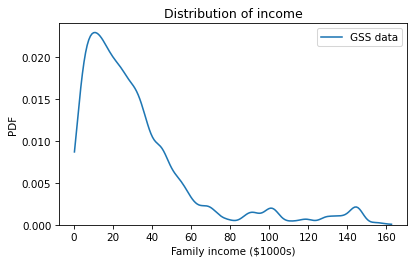

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(gss['realinc'] / 1000, label='GSS data', cut=0)

plt.xlabel('Family income ($1000s)')
plt.ylabel('PDF')
plt.title('Distribution of income')
plt.legend();

The distribution of income is skewed to the right; most household incomes are less than $60,000, but a few are substantially higher.
Here are the mean and standard deviation of the reported incomes.

In [6]:
mean_realinc = gss['realinc'].mean()
std_realinc = gss['realinc'].std()
print(mean_realinc, std_realinc)

32537.399981032493 30883.22609399141


The average family income in this sample is $32,537.
But if we ran the GSS survey again, the average might be higher or lower.
To see how much it might vary, we can use this function from the previous chapter to simulate the sampling process.

In [7]:
import numpy as np

def simulate_sample_mean(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.mean()

`simulate_sample_mean` takes as parameters the sample size and the mean and standard deviation.
It generates a sample from a normal distribution and returns the mean.

Before we call this function, we have to count the number of valid responses.

In [8]:
n_realinc = gss['realinc'].count()
n_realinc

64912

Now, if we call `simulate_sample_mean` once, we get a single value from the sampling distribution of the mean.

In [9]:
# set the random seed so we get the same results every time
np.random.seed(18)

In [10]:
simulate_sample_mean(n_realinc, mean_realinc, std_realinc)

32573.420195135117

If we call it many times, we get a random sample from the sampling distribution.

In [11]:
t1 = [simulate_sample_mean(n_realinc, mean_realinc, std_realinc)
      for i in range(1001)]

Here's what the sampling distribution looks like.

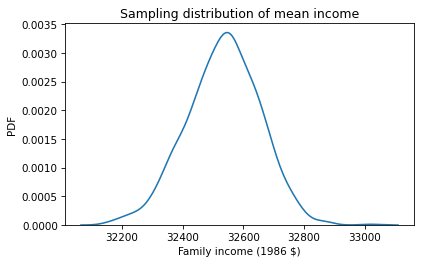

In [12]:
sns.kdeplot(t1)

plt.xlabel('Family income (1986 $)')
plt.ylabel('PDF')
plt.title('Sampling distribution of mean income');

This distribution shows how much we would expect the observed mean to vary if we ran the GSS survey again.
We'll use the following function to summarize the sampling distribution.

In [13]:
def summarize(t, digits=2, label=''):
    est = np.mean(t).round(digits)
    SE = np.std(t).round(digits)
    CI90 = np.percentile(t, [5, 95]).round(digits)
    data = [est, SE, CI90]
    columns = ['Estimate', 'SE', 'CI90']
    table = pd.DataFrame([data], index=[label], columns=columns)
    return table

In [14]:
summary1 = summarize(t1, digits=1)
summary1

,Estimate,SE,CI90
,32533.8,120.7,"[32331.4, 32724.2]"


The result shows the mean of the sampling distribution, the standard error, and a 90% confidence interval.
The mean of the sampling distribution is close to the mean of the data, as we expect.
The standard error quantifies the width of the sampling distribution, which is about $121.
Informally, that's how much we would expect the sample mean to change if we ran the survey again.
And if we ran the survey many times and computed the average income each time, we would expect 90\% of the results to fall in the range from 32,331 to 32,724.

In [15]:
mean_realinc

32537.399981032493

In this section, we used a normal distribution to simulate the sampling process.
The normal distribution is not a particularly good model for the distribution of income, but it works well enough for this example, and the results are reasonable.
In the next section we'll see an example where the normal distribution is not good enough and the results are not reasonable.
Then we'll see how to fix the problem.

## Estimating Percentiles

Suppose that, instead of estimating the average income, we want to estimate the 10th percentile.
Computing percentiles of income is often relevant to discussions of income inequality.

To compute the 10th percentile of the data, we can use the Pandas method `quantile`, which is similar to the NumPy function `percentile`, except that it drops `NaN` values.
Also, the parameter of `quantile` is a probability between 0 and 1, rather than a percentage between 0 and 100.

In [16]:
gss['realinc'].quantile(0.1)

5730.0

The 10th percentile of the sample is $5730, but if we collected another sample, the result might be higher or lower.
To see how much it would vary, we can use the following function to simulate the sampling process: `simulate_sample_percentile` generates a sample from a normal distribution and returns the 10th percentile.

In [17]:
def simulate_sample_percentile(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return np.percentile(sample, 10)

If we call it many times, the result is a sample from the sampling distribution of the 10th percentile.

In [18]:
t2 = [simulate_sample_percentile(n_realinc, mean_realinc, std_realinc)
      for i in range(1001)]

Here's what that sampling distribution looks like.

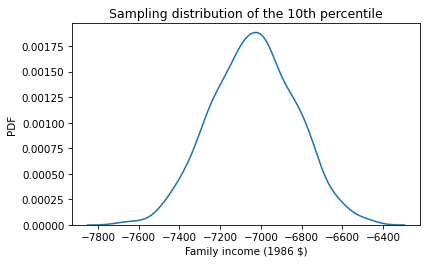

In [19]:
sns.kdeplot(t2)

plt.xlabel('Family income (1986 $)')
plt.ylabel('PDF')
plt.title('Sampling distribution of the 10th percentile');

We can see that something has gone wrong.
All of the values in the sampling distribution are negative, even though no one in the sample reported a negative income.
To see what happened, let's look at the distribution of reported incomes again compared to the normal distribution with the same mean and standard deviation.

In [20]:
from scipy.stats import norm

xs = np.linspace(-50, 150)
ys = norm(mean_realinc/1000, std_realinc/1000).pdf(xs)

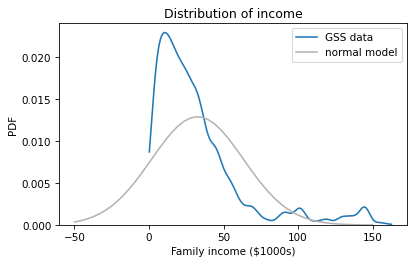

In [21]:
sns.kdeplot(gss['realinc'] / 1000, label='GSS data', cut=0)
plt.plot(xs, ys, color='0.7', label='normal model')

plt.xlabel('Family income ($1000s)')
plt.ylabel('PDF')
plt.title('Distribution of income')
plt.legend();

The problem is that the normal model extends past the lower bound of the observed values, so it doesn't produce sensible results.
Fortunately there is a simple alternative that is more robust: bootstrapping.

## Bootstrapping

Bootstrapping is a kind of resampling, based on the framework we saw in the previous chapter:

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/resampling.png)

The idea is that we treat the original sample as if it were the entire population, and simulate the sampling process by choosing random rows with replacement.
`DataFrame` provides a method called `sample` we can use to select a random sample of the rows.

In [22]:
bootstrapped = gss.sample(n=n_realinc, replace=True)
bootstrapped.shape

(64912, 9)

The argument `n=n_realinc` means that the bootstrapped sample has the same size as the original. 
`replace=True` means that sampling is done with replacement -- that is, the same row can be chosen more than once.
To see how many times each row appears in the bootstrapped sample, we can use `value_counts` and the `id` column, which contains a unique identifier for each respondent. 

In [23]:
repeats = bootstrapped['id'].value_counts()
repeats.head()

id
90     55
373    49
322    47
190    46
975    46
Name: count, dtype: int64

Several of the rows appear more than 40 times.
Since some rows appear many times, other rows don't appear at all.  To see how many, we can use `set` subtraction to count the values of `id` that appear in the original dataset but not the bootstrapped sample.

In [24]:
unused = set(gss['id']) - set(bootstrapped['id'])
len(unused)

228

Now we can use bootstrapping to generate a sampling distribution.
For example, the following function takes a `DataFrame`, generates a bootstrapped sample, and returns the average income.

In [25]:
def bootstrap_mean(df, varname):
    bootstrapped = df.sample(n=len(df), replace=True)
    return bootstrapped[varname].mean()

If we run it many times, we get a sample from the sampling distribution of the mean.

In [26]:
t3 = [bootstrap_mean(gss, 'realinc')
      for i in range(1001)]

Here's a summary of the results, compared to the results based on the normal model.

In [27]:
summary3 = summarize(t3)
table = pd.concat([summary1, summary3])
table.index=['normal model', 'bootstrapping']
table

,Estimate,SE,CI90
normal model,32533.80,120.70,"[32331.4, 32724.2]"
bootstrapping,32540.97,120.44,"[32345.43, 32735.15]"


The results from bootstrap sampling are consistent with the results based on the normal model.
Now let's see what happens when we estimate the 10th percentile.
The following function generates a bootstrapped sample and returns the 10th percentile.

In [28]:
def bootstrap_income_percentile(df):
    bootstrapped = df.sample(n=len(df), replace=True)
    return bootstrapped['realinc'].quantile(0.1)

We can use it to generate a sample from the sampling distribution of the 10th percentile.

In [29]:
t4 = [bootstrap_income_percentile(gss)
      for i in range(1001)]

Here are the results from bootstrapping compared to the results from the normal model.

In [30]:
summary2 = summarize(t2)
summary4 = summarize(t4)
table = pd.concat([summary2, summary4])
table.index=['normal model', 'bootstrapping']
table

,Estimate,SE,CI90
normal model,-7036.41,206.15,"[-7377.72, -6709.54]"
bootstrapping,5687.12,91.42,"[5512.5, 5827.5]"


The results from bootstrapping are more sensible -- the mean of the sampling distribution and the bounds of the confidence interval are positive and consistent with the 10th percentile of the data.

In [31]:
gss['realinc'].quantile(0.1)

5730.0

In general, bootstrapping is robust -- that is, it works well with many different distributions and many different statistics.
However, at the end of the chapter, we'll see one example where it fails.

## Working with Bigger Data

As sample size increases, errors due to random sampling get smaller.
To demonstrate this effect, we'll use data from the Behavioral Risk Factor Surveillance System (BRFSS) to estimate the average height for men in the United States.

First, let's read the 2021 data, which I have stored in an HDF file.
Instructions for downloading it are in the notebook for this chapter.

In [32]:
download('https://github.com/AllenDowney/ElementsOfDataScience/raw/v1/data/brfss_2021.hdf');

In [33]:
import pandas as pd

brfss = pd.read_hdf('brfss_2021.hdf', 'brfss')
brfss.shape

(438693, 10)

This dataset contains 438,693 rows, one for each respondent, and 10 columns, one for each variable in the extract.
Here are the first few rows.

In [34]:
brfss.head()

,SEQNO,HTM4,WTKG3,_SEX,_AGEG5YR,_VEGESU1,_INCOMG1,_LLCPWT,_HTM4G10,AGE
0,2021000001,150.0,32.66,2,11.0,2.14,3.0,744.745531,140.0,72.0
1,2021000002,168.0,NaN,2,10.0,1.28,NaN,299.137394,160.0,67.0
2,2021000003,165.0,77.11,2,11.0,0.71,2.0,587.862986,160.0,72.0
3,2021000004,163.0,88.45,2,9.0,1.65,5.0,1099.621570,160.0,62.0
4,2021000005,180.0,93.44,1,12.0,2.58,2.0,1711.825870,170.0,77.0


The `HTM4` column contains the respondents' heights in centimeters.

In [35]:
height = brfss['HTM4']

To select male respondents, we'll use the `SEX` column to make a Boolean `Series`.

In [36]:
male = (brfss['_SEX'] == 1)
male.sum()

203760

We can use `notna` and `sum` to count the number of male respondents with valid height data.

In [37]:
n_height = height[male].notna().sum()
n_height

193701

Here is the mean and standard deviation of these values.

In [38]:
mean_height = height[male].mean()
std_height = height[male].std()
mean_height, std_height

(178.14807357731763, 7.987083970017878)

The average height for men in the U.S. is about 178 cm.
To see how precise this estimate is, we can use bootstrapping to generate values from the sampling distribution.
To reduce computation time, I set the number of iterations to 201.

In [39]:
t5 = [bootstrap_mean(brfss[male], 'HTM4')
      for i in range(201)]

summarize(t5, digits=3)

,Estimate,SE,CI90
,178.148,0.018,"[178.121, 178.176]"


Because the sample size is so large, the standard error is small and the confidence interval is narrow.
This result suggests that our estimate is very precise, which is true in the sense that the error due to random sampling is small.

But there are other sources of error.
For example, the heights and weights in this dataset are self-reported, so they are vulnerable to **social desirability bias**, which is the tendency of people to represent themselves in a positive light. 

It's also possible that there are errors in recording the data.
In a previous year of the BRFSS, there are a suspicious number of heights recorded as 60 or 61 centimeters.
I suspect that many of them are six feet tall, or six feet and one inch, and something went wrong in recording the data.

And that brings us to the point of this example: 

> With large sample sizes, variability due to random sampling is small, but with real-world data, that often means that other sources of error are bigger. So we can't be sure that the estimate is accurate.

In fact, there is another source of error in this example that we have not taken into account: oversampling.

## Weighted Bootstrapping

By design, the BRFSS oversamples some demographic groups -- that is, people in some groups are more likely than others to appear in the sample.
If people in these groups are taller than others on average, or shorter, our estimated mean would not be accurate.

We encountered this issue in Chapter 7, where we used data from the National Survey of Family Growth (NSFG) to compute the average birth weight for babies in the United States.
In that example, we corrected for oversampling by computing a weighted mean.

In this example, we'll use a different method, **weighted bootstrapping**, to estimate the mean and compute a confidence interval.
The BRFSS dataset includes a column, `_LLCPWT`, that contains sampling weights.
The sampling weight for each respondent is the number of people in the population they represent.
People in oversampled groups have lower sampling weights; people in undersampled groups have higher sampling weights.
Here's what the range of values looks like.

In [40]:
brfss['_LLCPWT'].describe()

count    438693.000000
mean        560.851529
std        1136.781547
min           0.545800
25%          95.573000
50%         248.677287
75%         592.546811
max       49028.547000
Name: _LLCPWT, dtype: float64

The lowest sampling weight is about 0.5; the largest is about 49,000 -- so that's a very wide range!
We can take these weights into account by passing them as an argument to `sample`.
That way, the probability that any row is selected is proportional to its sampling weight.

In [41]:
n = len(brfss)
bootstrapped = brfss.sample(n=n, replace=True, weights='_LLCPWT')

As we saw with unweighted bootstrapping, the same row can appear more than once.
To see how many times, we can use `value_counts` and the `SEQNO` column, which contains a unique identifier for each respondent.

In [42]:
repeats = bootstrapped['SEQNO'].value_counts()
repeats.head()

SEQNO
2021000019    144
2021001348    132
2021000044    129
2021003808    127
2021000091    124
Name: count, dtype: int64

Some rows appear more than 100 times.
Most likely, these are the rows for people from undersampled groups, who have the highest sampling weights.

To see how many rows don't appear at all, we can use `set` subtraction to count the values of `SEQNO` that appear in the original dataset but not the sample.

In [43]:
unused = set(brfss['SEQNO']) - set(bootstrapped['SEQNO'])
len(unused)

14616

There are thousands of rows that don't appear in this sample, but they are not dropped altogether -- when we repeat this process, they will appear in other samples.

Now we can use weighted bootstrapping to generate values from the sampling distribution of the mean.
The following function uses `sample` and the `_LLCPWT` column to generate a bootstrapped sample, then returns the average height.

In [44]:
def weighted_bootstrap_mean(df):
    n = len(df)
    sample = df.sample(n=n, replace=True, weights='_LLCPWT')
    return sample['HTM4'].mean()

I'll test this function with a `DataFrame` that contains only male respondents.
If we run it once, we get a single value from the sampling distribution of the weighted mean.

In [45]:
male_df = brfss[male]
weighted_bootstrap_mean(male_df)

177.569630553049

If we run it many times, we get a random sample from the sampling distribution.

In [46]:
t6 = [weighted_bootstrap_mean(male_df) 
      for i in range(201)]

summarize(t6, digits=3)

,Estimate,SE,CI90
,177.541,0.018,"[177.513, 177.573]"


The mean of the sampling distribution estimates the average height for men in the U.S., corrected for oversampling.
If we compare it to the unweighted mean we computed, it is a little lower.

In [47]:
print(np.mean(t6), mean_height)

177.54149968876962 178.14807357731763


So it seems like people in the oversampled groups are taller than others, on average, by enough to bring the unweighted mean up by about half a centimeter.

The difference between the weighted and unweighted averages is bigger than the width of the confidence interval.
So in this example the error if we fail to correct for oversampling is bigger than variability due to random sampling.

## Correlation and Regression

Bootstrap resampling can be used to estimate other statistics and their sampling distributions.
For example, in Chapter 9 we computed the correlation between height and weight, which is about 0.47.

In [48]:
var1, var2 = 'HTM4', 'WTKG3'
corr = brfss[var1].corr(brfss[var2])
corr

0.4693981914367917

That correlation does not take into account oversampling.
We can correct it with this function, which generates a weighted bootstrapped sample and uses it to compute the correlation of the columns specified by `var1` and `var2`.

In [49]:
def weighted_bootstrap_corr(df, var1, var2):
    n = len(df)
    sample = df.sample(n=n, replace=True, weights='_LLCPWT')
    corr = sample[var1].corr(sample[var2])
    return corr

**Exercise:** Use this function to draw 101 values from the sampling distribution of the correlation between height and weight.
What is the mean of these values?  Is it substantially different from the correlation we computed without correcting for oversampling?
Compute the standard error and 90% confidence interval for the estimated correlation.

In [50]:
# Solution

t7 = [weighted_bootstrap_corr(brfss, 'HTM4', 'WTKG3')
      for i in range(101)]

summarize(t7, digits=5)

,Estimate,SE,CI90
,0.45492,0.00125,"[0.45244, 0.45678]"


In [51]:
# Solution

# The estimated correlation with weighted bootstrapping is
# slightly smaller, but the difference is not enough to matter 
# in practice.

# The error due to oversampling, although small,
# is bigger than variability due to random sampling,
# which is small because the sample size is so large.

**Exercise:** In Chapter 9 we also computed the slope of the regression line for weight as a function of height.
Here's the result.

In [52]:
from scipy.stats import linregress

subset = brfss.dropna(subset=['WTKG3', 'HTM4'])
res = linregress(subset['HTM4'], subset['WTKG3'])
res.slope

0.9366891536604244

The estimated slope is 0.94 kg/cm, which means that we expect someone 1 cm taller than average to be about 0.94 kg heavier than average.

Write a function called `weighted_bootstrap_slope` that takes a `DataFrame`, generates a weighted bootstrapped sample, runs `linregress` with height and weight, and returns the slope of the regression line.

Run it 101 times and collect the results.  Use the sampling distribution to compute the mean of the slope estimates, standard error, and a 90% confidence interval.

In [53]:
# Solution

def weighted_bootstrap_slope(df):
    n = len(df)
    sample = df.sample(n=n, replace=True, weights='_LLCPWT')
    subset = sample.dropna(subset=['WTKG3', 'HTM4'])
    res = linregress(subset['HTM4'], subset['WTKG3'])
    return res.slope

In [54]:
# Solution

t8 = [weighted_bootstrap_slope(brfss)
      for i in range(101)]

summarize(t8, digits=5)

,Estimate,SE,CI90
,0.90525,0.00307,"[0.90018, 0.90964]"


In [55]:
# Solution

# In this example, again the value we get with weighted resampling is a little
# different, but not enough to matter in practice.

# Because the sample size is large, the standard error is small and 
# the confidence interval is narrow, but there might be sources of error,
# other than random sampling, that have a bigger effect.

## Limitations of Bootstrapping

One limitation of bootstrapping is that it can be computationally expensive.
With small datasets, it is usually fast enough that we can generate a thousand values from the sampling distribution, which means that we can compute standard errors and confidence intervals precisely.
With larger datasets, we can cut the computation time by generating fewer values.
With 100-200 values, the standard errors we get are usually precise enough, but the bounds of the confidence intervals might be noisier.

The other limitation, which can be more problematic, is that bootstrap sampling does not work well with datasets that contain a small number of different values.
To demonstrate, I'll select data from the GSS for one year, 2018:

In [56]:
one_year = gss['year']==2018
gss2018 = gss[one_year]

And I'll use bootstrapping to generate values from the sampling distribution of the 10th percentile.

In [57]:
t9 = [bootstrap_income_percentile(gss2018)
      for i in range(1001)]

Here are the results.

In [58]:
summary9 = summarize(t9)
summary9

,Estimate,SE,CI90
,5155.46,223.92,"[5107.5, 5107.5]"


The estimate and the standard error look plausible at first glance, but the width of the confidence interval is 0, which suggests that something has gone wrong!
The problem is that `realinc` is not really a numerical variable -- it is a categorical variable in disguise.
Using `value_counts`, we can see that there are only 26 distinct values in this column.

In [59]:
len(gss2018['realinc'].value_counts())

26

The reason is that the GSS does not ask respondents to report their incomes.
Instead, it gives them a list of ranges and asks them to pick the range their income falls in. 
Then GSS analysts compute the midpoint of each range and convert to 1986 dollars by adjusting for inflation.
As a result, there are only 26 distinct values for each year of the survey.
When we generate a bootstrapped sample and compute the 10th percentile, we get a small subset of them.
Here are the values that appear in our sample.

Details of the methodology are in available [here](https://gss.norc.org/Documents/reports/methodological-reports/MR101%20Getting%20the%20Most%20Out%20of%20the%20GSS%20Income%20Measures.pdf).

In [60]:
pd.Series(t9).value_counts().sort_index()

5107.5    955
5221.0      1
5448.0      1
5561.5      1
5675.0      1
5902.0      2
6015.5      1
6129.0      2
6242.5     37
Name: count, dtype: int64

There are only four different values, and one of them appears more than 95% of the time.
When we compute a 90% confidence interval, this value is both the 5th and the 95th percentile.

Bootstrapping works well for most distributions and most statistics, but the one thing it can't handle is lack of diversity in the data.
Fortunately, this problem can be solved.
The cause of the problem is that the data have been discretized excessively, so the solution is to smooth it.
Jittering is one option.
Another is to use kernel density estimation (KDE).

## Resampling with KDE

We have used KDE several times to estimate and plot a probability density based on a sample.
We can also use it to smooth data that have been discretized.

In Chapter 8 we saw that the distribution of income is well modeled by a lognormal distribution, so if we take the log of income, it is well modeled by a normal distribution.
Here are the logarithms of the income data.

In [61]:
log_realinc = np.log10(gss2018['realinc'].dropna())

And here's what the estimated density looks like.

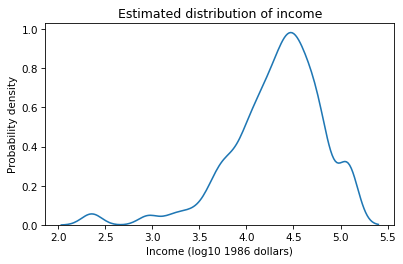

In [62]:
sns.kdeplot(log_realinc)

plt.xlabel('Income (log10 1986 dollars)')
plt.ylabel('Probability density')
plt.title('Estimated distribution of income');

To draw samples from this distribution, we'll use a Scipy function called `gaussian_kde`, which takes the data and returns an object that represents the estimated density.

In [63]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(log_realinc)

`kde` provides a method called `resample` that draws random values from the estimated density.
As we've done in previous examples, we'll generate a resampled dataset with the same size as the original -- which is stored as `kde.n`.

In [64]:
sample = kde.resample(kde.n)

Now we can compute the 10th percentile and convert from a logarithm to a dollar value.

In [65]:
10 ** np.percentile(sample, 10)

5235.936465561343

The result is a random value from the sampling distribution of the 10th percentile.
The following function encapsulates these steps.

In [66]:
def resample_kde_percentile(kde):
    sample = kde.resample(kde.n)
    return 10 ** np.percentile(sample, 10)

Now we can generate a sample from the sampling distribution.

In [67]:
t10 = [resample_kde_percentile(kde)
       for i in range(1000)]

summary10 = summarize(t10)

The following table compares the result to the previous result with bootstrapping.

In [68]:
table = pd.concat([summary9, summary10])
table.index=['bootstrapping', 'KDE resampling']
table

,Estimate,SE,CI90
bootstrapping,5155.46,223.92,"[5107.5, 5107.5]"
KDE resampling,5097.59,246.25,"[4692.62, 5485.93]"


The means and standard errors are about the same with either method.
But the confidence interval we get from KDE resampling is sensible.

## Summary

There are ten examples in this chapter, so let's review them:

1. First we used resampling based on a normal model to estimate average family income in the GSS and compute a confidence interval.

2. Then we used the same method to estimate the 10th percentile of income, and we found that all of the values in the sampling distribution are negative. The problem is that the normal model does not fit the distribution of income.  

3. To solve this problem, we switched to bootstrap sampling. First we estimated average family income and confirmed that the results are consistent with the results based on the normal model.

4. Then we used bootstrapping to estimate the 10th percentile of income. The results are much more plausible.

5. Next we used data from the BRFSS to estimate the average height of men in the U.S.  Since this dataset is large, the confidence interval is very small.  That means that the estimate is precise, in the sense that variability due to random sampling is small, but we don't know whether it is accurate, because there are other sources of error.

6. One of those sources of error is oversampling -- that is, some people are more likely to appear in the sample than others.  In the BFRSS, each respondent has a sampling weight that indicates how many people in the population they represent.  We used these weights to do weighted bootstrapping, and found that the error due to oversampling is larger than the variability due to random sampling.

7. In one exercise you used weighted bootstrapping to estimate the correlation of height and weight and compute a confidence interval.

8. In another exercise you estimated the slope of a regression line and computed a confidence interval.

9. Then I demonstrated a problem with bootstrap sampling when the dataset has only a few different values,

10. And presented a solution using KDE to smooth the data and draw samples from an estimated distribution.

In the exercise below, you can work on one more example.
It is a little more involved than the previous exercises, but I will walk you through it.

**Exercise:** In Chapter 10 we used logistic regression to model support for legalizing marijuana as a function of age, sex, and education level.
Going back to that example, let's explore changes in support over time and generate predictions for the next decade.

To prepare the data for logistic regression, we have to recode the `grass` column so `1` means in favor of legalization and `0` means not in favor.

In [69]:
gss['grass'] = gss['grass'].replace(2, 0)
gss['grass'].value_counts()

grass
0.0    25997
1.0    12672
Name: count, dtype: int64

As explanatory variables we'll use `year` and `year` squared, which I'll store in a column called `year2`.
Subtracting 1990 from `year` before squaring keeps the values of `year2` relatively small, which makes logistic regression work better. 

In [111]:
gss['year2'] = (gss['year'] - 1990) ** 2.0

Now we can run the model like this:

In [112]:
import statsmodels.formula.api as smf

formula = 'grass ~ year + year2'
results = smf.logit(formula, data=gss).fit()

Optimization terminated successfully.
         Current function value: 0.585064
         Iterations 5


In [113]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  grass   No. Observations:                38669
Model:                          Logit   Df Residuals:                    38666
Method:                           MLE   Df Model:                            2
Date:                Wed, 08 May 2024   Pseudo R-squ.:                 0.07506
Time:                        14:15:47   Log-Likelihood:                -22624.
converged:                       True   LL-Null:                       -24460.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.0901      2.372    -17.746      0.000     -46.739     -37.441
year           0.0205      0.001     17.203      0.000       0.018       0.023
year2          0.0016    6.3e-05     25.436      0.000       0.001       0.002
==============================================================================
"""

To generate predictions, I'll create a `DataFrame` with a range of values of `year` up to 2030, and corresponding values of `year2`.

In [115]:
years = np.linspace(1972, 2030)
df_pred = pd.DataFrame()
df_pred['year'] = years
df_pred['year2'] = (years - 1990) **2

pred = results.predict(df_pred)

I'll use `groupby` to compute the fraction of respondents in favor of legalization during each year.

In [116]:
grass_by_year = gss.groupby('year')['grass'].mean()

The following function plots the data and decorates the axes.

In [117]:
def plot_data():
    grass_by_year.plot(style='o', alpha=0.5, label='data')
    plt.xlabel('Year')
    plt.ylabel('Fraction in favor')
    plt.title('Support for legalization of marijuana')
    plt.legend(loc='upper left');

Here's what the predictions look like, plotted along with the data.

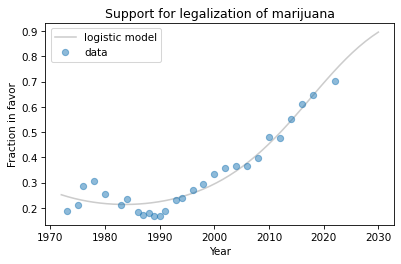

In [118]:
plt.plot(years, pred, label='logistic model', color='gray', alpha=0.4)
plot_data()

The model fits past data reasonably well and makes plausible predictions for the next decade, although we can never be sure that trends like this will continue.

This way of representing the results could be misleading because it does not show our uncertainty about the predictions.
Random sampling is just one source of uncertainty among many, and for this kind of prediction it is certainly not the biggest.
But it is the easiest to quantify, so let's do it, if only as an exercise.

Write a function called `bootstrap_regression_line` that takes a `DataFrame` as a parameter, uses `sample` to resample the rows, runs the logistic regression model, generates predictions for the rows in `df_pred`, and returns the predictions.

Call this function 101 times and save the results as a list of `Series` objects.
To visualize the results, you have two options:

1. Loop through the list and plot each prediction using a gray line with a low value of `alpha`.  The overlapping lines will form a region showing the range of uncertainty over time.

2. Pass the list of `Series` to `np.percentile` with the argument `axis=0` to compute the 5th and 95th percentile in each column.  Plot these percentiles as two lines, or use `plt.fill_between` to plot a shaded region between them.

In [119]:
# Solution

def bootstrap_regression_line(df):
    n = len(df)
    sample = df.sample(n=n, replace=True)
    results = smf.logit(formula, data=sample).fit(disp=False)
    pred = results.predict(df_pred)
    return pred

In [120]:
# Solution

t11 = [bootstrap_regression_line(gss)
       for i in range(101)]

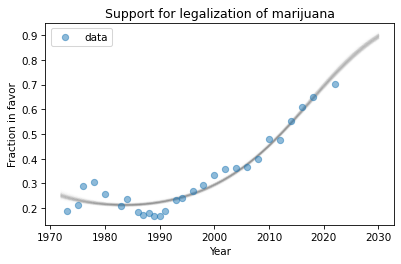

In [121]:
# Solution

for pred in t11:
    plt.plot(years, pred, color='gray', alpha=0.01)
plot_data()

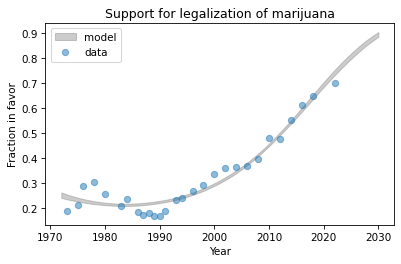

In [122]:
# Solution

low, high = np.percentile(t11, [5, 95], axis=0)
plt.fill_between(years, low, high, 
                 color='gray', alpha=0.4, label='model')
plot_data()

In [123]:
# Solution

# In this example, the width of the CI is quite narrow, which might suggest that
# the predictions are nearly certain. But remember that the CI only quantifies
# uncertainty due to random sampling. In this example, there are many other sources
# of uncertainty; one of the big ones is that there is no guarantee that the trends
# we see in the past will continue in the future.

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)